## net_sonar dataset creation

## Image selection
The extraction and exporting (after they have been enhanced) of images happens in the solaqua_sonar_dataprocessing.ipynb. They are exported to their own folder ../data/exports/sonar/net_sonar/labelrady/images


We select the following bags: (200 imgs per)
- bag1:  2024-08-20_13-57-42 - Net is medium away. Oritentation varies. Some "folds" effect at the end. Some fish here and there. 
- bag2:  2024-08-20_17-02-00 - Net is close, far at the end. Stable data of the net. Few fishes on the inside. 
- bag3:  2024-08-20_13-55-34 - Net is far away, therefore weaker signal of net. Orientation varies a little. Few fish at the end. 
- bag4:  2024-08-20_14-31-29 - Net is far away. Few fish before the end. Net is a little wobbly. 
- bag5:  2024-08-20_14-38-37 - Net is medium away. Mostly stable data, very clear lines. Very few fishes on inside.
- bag6:  2024-08-20_14-34-07 - Net is medium-close away. Orientation constant. More unstable at the end. Very few fishes on inside.
- bag7:  2024-08-20_14-16-05 - Net is medium-close away. Unstable net - orientation and wobbles. Some fishes on inside.
- bag8:  2024-08-20_18-50-22 - Net is close. Stable. No fish inside.
- bag9:  2024-08-20_16-47-54 - Net is medium and cloase away. Unstable at times, inconsistent. Some fish inside.
- bag10: 2024-08-20_17-14-36 - Net is medium-close. Fish inside, ALOT at the end, difficult to understand net at the end. 


Naming convention:
- \<bagX>_<ts_ns>.png

## Dataprocessing and Enhancement

This is done in solaqua_sonar_dataprocessing.ipynb. We use the config-file found in configs/net_sonar_labelingview_config.py. We do this processing to easier to the labeling. 

## Labeling



This is manually done using Label Studio. We now have 2000 labels in the data/net_labes_raw.

## Splitting into train, val and test


### get the labels

In [1]:
import os
import re
import shutil
from pathlib import Path
from collections import Counter
from typing import Optional

# ---- Config ----
REPO_ROOT     = Path("..")
DATA_ROOT     = REPO_ROOT / "data"
SRC_LABEL_ROOT = DATA_ROOT / "net_labels_raw"        # <-- raw labels live here
DST_DATA_ROOT  = DATA_ROOT / "net_sonar"             # <-- new dataset root
DST_IMG_ROOT   = DST_DATA_ROOT / "images"            # created empty for now
DST_LBL_ROOT   = DST_DATA_ROOT / "labels"            # labels/{train,val,test}

# Split by BAG NUMBER (from filenames like: <id>-bag3_<timestamp>.txt)
TRAIN_BAGS = {1, 2, 4, 6, 7, 8, 9}
VAL_BAGS   = {5}
TEST_BAGS  = {3, 10}

LABEL_EXTS   = {".txt"}    # YOLO label files
PATTERN      = re.compile(r"-bag(\d+)_")  # captures the bag number

# ---- Helpers ----
def ensure_dirs():
    (DST_LBL_ROOT / "train").mkdir(parents=True, exist_ok=True)
    (DST_LBL_ROOT / "val").mkdir(parents=True, exist_ok=True)
    (DST_LBL_ROOT / "test").mkdir(parents=True, exist_ok=True)
    DST_IMG_ROOT.mkdir(parents=True, exist_ok=True)

def split_for_bag(bag_num: int) -> Optional[str]:
    if bag_num in TRAIN_BAGS:
        return "train"
    if bag_num in VAL_BAGS:
        return "val"
    if bag_num in TEST_BAGS:
        return "test"
    return None

def new_filename(original_name: str) -> str:
    """
    Remove the unimportant-id prefix up to and including the first '-'.
    Example: '0a05d92c-bag3_1724...txt' -> 'bag3_1724...txt'
    """
    try:
        return original_name.split("-", 1)[1]
    except IndexError:
        return original_name

def copy_or_link(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    
    shutil.copy2(src, dst)

def build_split():
    ensure_dirs()
    counts = Counter()
    skipped = 0
    unparsable = []

    files = [p for p in SRC_LABEL_ROOT.rglob("*") if p.is_file() and p.suffix.lower() in LABEL_EXTS]

    for p in files:
        m = PATTERN.search(p.name)
        if not m:
            unparsable.append(p.name)
            continue

        bag_num = int(m.group(1))
        split = split_for_bag(bag_num)
        if split is None:
            skipped += 1
            continue

        # Remove prefix
        out_name = new_filename(p.name)
        dst = DST_LBL_ROOT / split / out_name

        # Handle collision by appending __dup#
        if dst.exists():
            stem, ext = dst.stem, dst.suffix
            k = 1
            while True:
                candidate = dst.with_name(f"{stem}__dup{k}{ext}")
                if not candidate.exists():
                    dst = candidate
                    break
                k += 1

        copy_or_link(p, dst)
        counts[split] += 1

    print("=== Done ===")
    print(f"train: {counts['train']}")
    print(f"val:   {counts['val']}")
    print(f"test:  {counts['test']}")
    print(f"skipped: {skipped}")

    if unparsable:
        print("\n[WARN] Could not parse bag number from these filenames:")
        for n in unparsable[:20]:
            print("  -", n)
        if len(unparsable) > 20:
            print(f"  ... and {len(unparsable)-20} more")

# Execute
build_split()


=== Done ===
train: 1400
val:   200
test:  400
skipped: 0


### get the images

In [1]:
# Build images for the net_sonar dataset by matching label timestamps
# Run in notebooks/net_sonar_creation.ipynb  (Python 3.9+)
import sys
from pathlib import Path

# Add repo root to sys.path so "utils and config" can be imported
REPO_ROOT = Path("..").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("Repo root added to sys.path:", REPO_ROOT)

# from pathlib import Path
import re
from collections import defaultdict, Counter
from typing import Optional, Dict, Set
from tqdm import tqdm
import numpy as np

# your utils
from utils.loader import load_sonoptix_frame_from_bag
from utils.sonar_visualization import save_cone_view_image, enhance_cfc_style
from configs.cfc_gray_config import cfc_gray_config

# ----------------------------
# PATHS / CONFIG
# ----------------------------
REPO_ROOT   = Path("..")
DATA_ROOT   = REPO_ROOT / "data"

BAGS_ROOT   = DATA_ROOT / "bags"                   # where the .bag (or similar) files are
LABELS_ROOT = DATA_ROOT / "net_sonar" / "labels"   # labels/{train,val,test}
IMAGES_ROOT = DATA_ROOT / "net_sonar" / "images"   # images/{train,val,test}

# ensure split folders exist
for split in ("train", "val", "test"):
    (IMAGES_ROOT / split).mkdir(parents=True, exist_ok=True)

# bag number -> timestamped stem (adjust if your stems differ)
BAG_ID_TO_STEM: Dict[int, str] = {
    1: "2024-08-20_13-57-42",
    2: "2024-08-20_17-02-00",
    3: "2024-08-20_13-55-34",
    4: "2024-08-20_14-31-29",
    5: "2024-08-20_14-38-37",
    6: "2024-08-20_14-34-07",
    7: "2024-08-20_14-16-05",
    8: "2024-08-20_18-50-22",
    9: "2024-08-20_16-47-54",
    10:"2024-08-20_17-14-36",
}

# enhancer + sonar config (you already have this in your notebook/environment)
ENHANCER = enhance_cfc_style
CFG =  cfc_gray_config 

# loader control (stop conditions)
MAX_FRAMES_PER_BAG = 10000     # hard upper bound; will stop earlier when all labels found
MAX_CONSEC_ERRORS  = 500        # break if we see too many consecutive load failures (end-of-bag)
PRINT_EVERY        = 200

# label filename pattern: bagX_timestamp.txt  (X = 1..10, timestamp = ns)
LBL_NAME_RE = re.compile(r"^bag(\d+)_(\d+)\.txt$")
# ----------------------------


def index_label_timestamps(labels_root: Path):
    """
    Read labels/{train,val,test} and build:
      split_to_bag_ts[split][bag_num] = set({timestamps})
    """
    split_to_bag_ts: Dict[str, Dict[int, Set[int]]] = {
        "train": defaultdict(set),
        "val":   defaultdict(set),
        "test":  defaultdict(set),
    }
    for split in ("train", "val", "test"):
        split_dir = labels_root / split
        if not split_dir.exists():
            continue
        for p in split_dir.glob("*.txt"):
            m = LBL_NAME_RE.match(p.name)
            if not m:
                # ignore unparsable names
                continue
            bag_num = int(m.group(1))
            ts = int(m.group(2))
            split_to_bag_ts[split][bag_num].add(ts)
    return split_to_bag_ts


def find_bag_file(stem: str) -> Optional[Path]:
    """
    Try to locate the bag file for a given timestamped stem.
    We search for files starting with the stem (e.g., '2024-08-20_13-57-42')
    and prefer something that contains 'video' if present.
    """
    candidates = list(BAGS_ROOT.glob(f"{stem}*"))
    if not candidates:
        return None
    # prefer a file whose name contains 'video'
    for c in candidates:
        if "video" in c.stem.lower():
            return c
    # otherwise take the first
    return candidates[0]


def export_images_for_bag(split: str, bag_num: int, timestamps: Set[int]) -> Counter:
    """
    Iterate frames of a bag and export cone-view jpgs whose t_ns matches label timestamps.
    Saves to data/net_sonar/images/{split}/bag{bag_num}_{t_ns}.jpg
    """
    stem = BAG_ID_TO_STEM.get(bag_num)
    if stem is None:
        tqdm.write(f"[WARN] No stem for bag{bag_num}")
        return Counter()

    bag_path = find_bag_file(stem)
    if bag_path is None:
        tqdm.write(f"[WARN] Bag file not found for stem '{stem}' in {BAGS_ROOT}")
        return Counter()

    out_dir = IMAGES_ROOT / split
    remaining = set(timestamps)  # copy so we can remove when saved
    saved = 0
    errors = 0
    frame_idx = 0
    stats = Counter()

    pbar = tqdm(total=len(remaining), desc=f"{split}: bag{bag_num} -> images", leave=False)
    try:
        while remaining and frame_idx < MAX_FRAMES_PER_BAG and errors < MAX_CONSEC_ERRORS:
            try:
                M_raw, t_ns = load_sonoptix_frame_from_bag(bag_path, frame_idx)
            except Exception:
                errors += 1
                frame_idx += 1
                continue

            # reset error streak if we successfully loaded a frame
            errors = 0

            if M_raw is None or not isinstance(M_raw, np.ndarray):
                frame_idx += 1
                continue

            if t_ns in remaining:
                out_name = f"bag{bag_num}_{t_ns}.jpg"
                out_path = out_dir / out_name

                save_cone_view_image(
                    M_raw,
                    CFG,
                    out_path=out_path,
                    use_enhanced=True,
                    enhancer=ENHANCER,
                )

                remaining.remove(t_ns)
                saved += 1
                pbar.update(1)

            frame_idx += 1

            if saved % PRINT_EVERY == 0 and saved > 0:
                tqdm.write(f"{split} bag{bag_num}: saved {saved}/{len(timestamps)}")

    finally:
        pbar.close()

    if remaining:
        tqdm.write(f"[INFO] {split} bag{bag_num}: {len(remaining)} labeled timestamps not found in bag frames.")

    stats["saved"] = saved
    stats["expected"] = len(timestamps)
    stats["missing"] = len(remaining)
    return stats


def run_all():
    split_index = index_label_timestamps(LABELS_ROOT)
    print("Indexed label timestamps per split/bag:")
    for split, d in split_index.items():
        total = sum(len(v) for v in d.values())
        print(f"  {split}: {total} labels across bags {sorted(d.keys())}")

    grand = Counter()
    for split, bag_map in split_index.items():
        for bag_num, ts_set in bag_map.items():
            stats = export_images_for_bag(split, bag_num, ts_set)
            grand.update({f"{split}_saved": stats["saved"]})
            grand.update({f"{split}_expected": stats["expected"]})
            if stats["missing"]:
                grand.update({f"{split}_missing": stats["missing"]})

    print("\n=== Summary ===")
    for k, v in sorted(grand.items()):
        print(f"{k}: {v}")
    print(f"\nImages written under: {IMAGES_ROOT}")

# go!
run_all()


Repo root added to sys.path: /cluster/home/henrban/SOLAQUA-UOD/solaqua
Indexed label timestamps per split/bag:
  train: 1400 labels across bags [1, 2, 4, 6, 7, 8, 9]
  val: 200 labels across bags [5]
  test: 400 labels across bags [3, 10]


train bag4: saved 200/200


train bag8: saved 200/200


train bag2: saved 200/200


train bag6: saved 200/200


train bag7: saved 200/200


train bag9: saved 200/200


train bag1: saved 200/200


val bag5: saved 200/200


test bag3: saved 200/200


test bag10: saved 200/200

=== Summary ===
test_expected: 400
test_saved: 400
train_expected: 1400
train_saved: 1400
val_expected: 200
val_saved: 200

Images written under: ../data/net_sonar/images


### Write YAML

In [3]:
from pathlib import Path

# Base paths
NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent

DATA = ROOT / "data" / "net_sonar"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "val"
IMAGES_TEST =  DATA / "images" / "test"


# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
path: {DATA.as_posix()}
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test: {IMAGES_TEST.as_posix()}


nc: 1
names: 
    - net
"""

# Write YAML next to the dataset
yaml_path = DATA / "net_sonar.yaml"
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


Wrote: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/net_sonar.yaml

Preview:


path: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar
train: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/images/train
val:   /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/images/val
test: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/images/test


nc: 1
names: 
    - net



## Validation of dataset

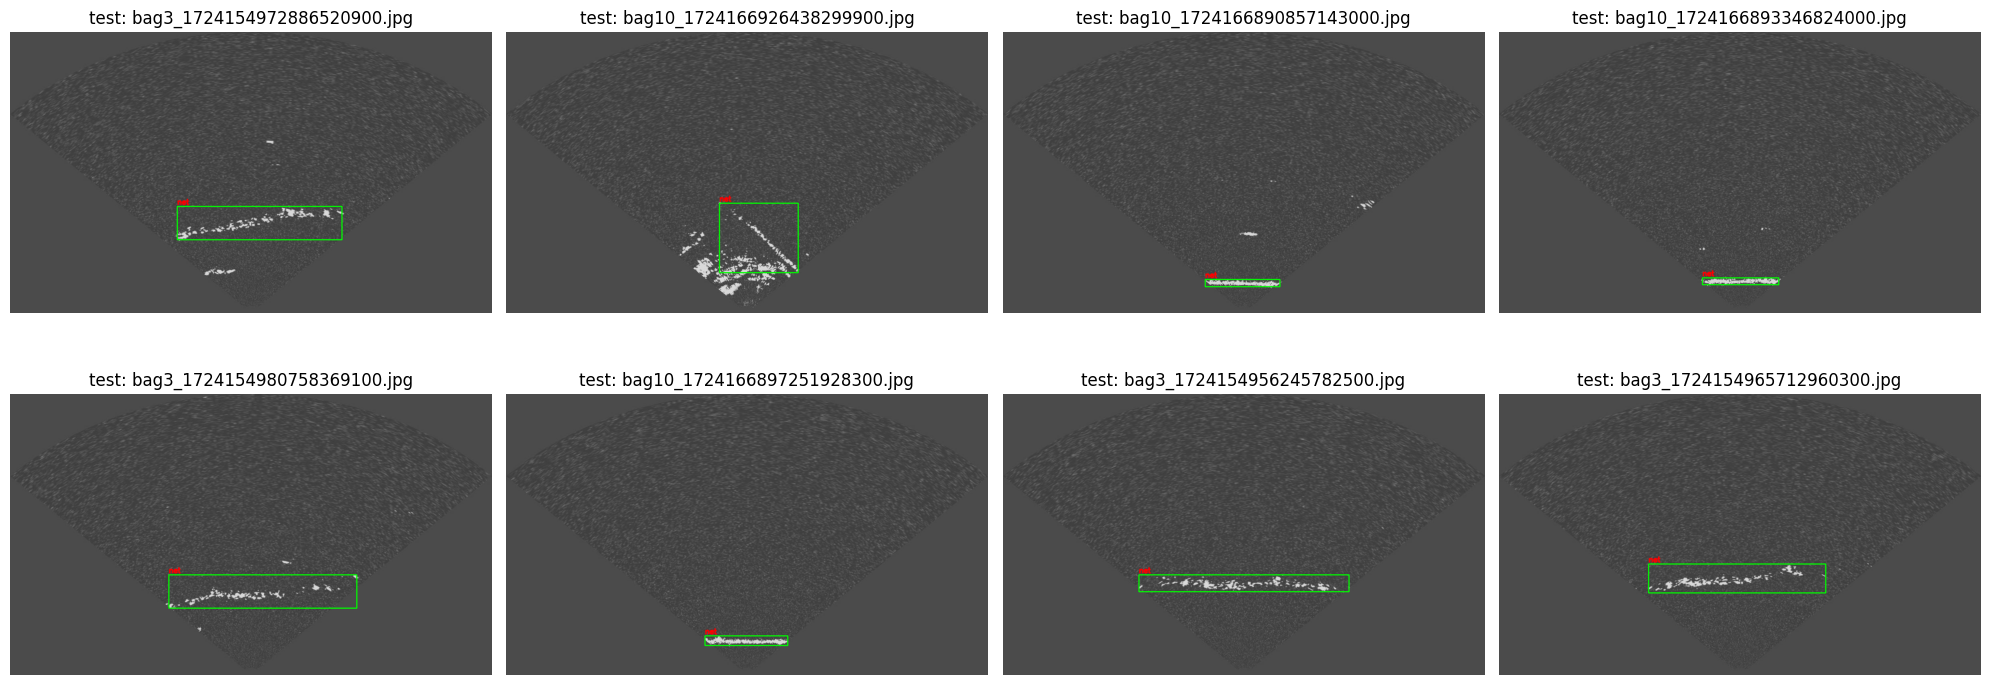

In [12]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# ---------------- config ----------------
DATA_ROOT = Path("../data/net_sonar")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "test"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4


CFC_NAMES = [
    "net"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, CFC_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()


### visualize spesific

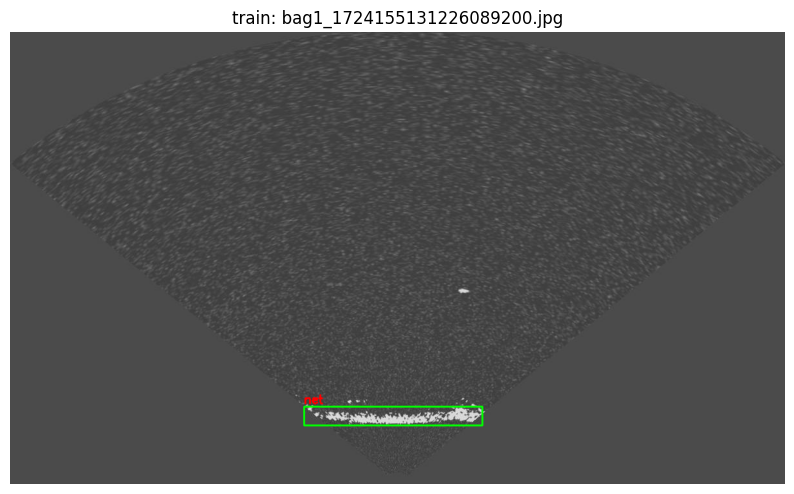

(PosixPath('../data/net_sonar/images/train/bag1_1724155131226089200.jpg'),
 PosixPath('../data/net_sonar/labels/train/bag1_1724155131226089200.txt'))

In [14]:
import cv2
import matplotlib.pyplot as plt
import re
from pathlib import Path

# ----------------------------------------------------------
# CONFIG (update if needed)
# ----------------------------------------------------------
DATA_ROOT = Path("../data/net_sonar")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

CLASS_NAMES = ["net"]   # only one class
# ----------------------------------------------------------

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]

    if not label_file.exists():
        print(f"❌ Label file not found: {label_file}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for line in label_file.read_text().strip().splitlines():
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)

        # clamp
        x1 = max(0, min(w-1, x1))
        y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2))
        y2 = max(0, min(h-1, y2))

        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        name = names[cls] if cls < len(names) else f"id{cls}"
        cv2.putText(img, name, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def show_single_labeled_image(label_name: str, split: str = "test"):
    """
    label_name: filename of the txt label (e.g. 'bag3_17245555555555.txt')
    split: 'train', 'val', or 'test'
    """

    label_path = LAB_ROOT / split / label_name
    if not label_path.exists():
        raise FileNotFoundError(f"Label not found: {label_path}")

    # find matching image: same stem, any valid extension
    stem = label_path.stem
    possible_exts = [".jpg", ".jpeg", ".png", ".bmp"]

    img_path = None
    for ext in possible_exts:
        candidate = IMG_ROOT / split / f"{stem}{ext}"
        if candidate.exists():
            img_path = candidate
            break

    if img_path is None:
        raise FileNotFoundError(f"No image found for stem {stem} in {IMG_ROOT/split}")

    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise RuntimeError(f"Failed to load image: {img_path}")

    vis = draw_yolo_labels(img_bgr, label_path, CLASS_NAMES)

    plt.figure(figsize=(10,8))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{split}: {img_path.name}")
    plt.show()

    return img_path, label_path


show_single_labeled_image("bag1_1724155131226089200.txt", split="train")


Things are looking alright!

# Training and Evaluation

This is done under the aqua_yolo folder in its own notebook as I feel like it makes more sense having that code there. Its the aquayolo model we are doing training on. 